In [1]:
import pandas as pd
import numpy as np
RSEED = 42
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

import tensorflow as tf
np.random.seed(RSEED)
tf.random.set_seed(RSEED)
np.random.seed(RSEED)
from tensorflow.keras.layers import Concatenate

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score  


from survive import SurvivalData
from survive import KaplanMeier


import sys 
sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/AE')
import models, run_models

sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/helper_functions')
import helpers, clustering_helpers


import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import warnings
warnings.filterwarnings("ignore")


2023-11-09 09:45:52.028027: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In  models file
Using TensorFlow backend
In run_models python file


### Read the datasets 

In [2]:
time_series_2d = np.load('preprocessing/representations/time_series_2d_scaled.npy')
time_series_3d = np.load('preprocessing/representations/time_series_3d_scaled.npy')

static = pd.read_csv('preprocessing/representations/static_eq.csv')
time_series_2d_df = pd.read_csv('preprocessing/representations/time_series_2d_scaled_df.csv')
time_series_3d_df = pd.read_csv('preprocessing/representations/time_series_3d.csv')


folder_sepsis = 'sepsis3_queries/data'
sepsis3 = pd.read_csv(f'{folder_sepsis}/sepsis-df-3.csv')


In [3]:
#static = static.fillna(-1)
static = static.set_index('icustay_id')
static = static.loc[:, static.gt(0).mean() >= .1]  

static = static[['vent', 'F', 'M', 'adults', 'seniors', 'race_white', 'race_other',
    'gcs_13_15', 'gcs_9_12', 'gcs_<8', 'congestive_heart_failure',
    'cardiac_arrhythmias', 'hypertension', 'other_neurological',
    'chronic_pulmonary',  'hypothyroidism',
    'renal_failure', 'liver_disease', 'coagulopathy', 'fluid_electrolyte',
    'alcohol_abuse', 'depression', 'diabetes', 'circulatory',
    'circulatory_infectious_congenital', 'nervous_and_sense',
    'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
    'mental']]

In [4]:
time_series_2d.shape

(5784, 24, 47)

In [5]:
time_series_3d.shape

(5784, 24, 47)

In [6]:
time_series_2d_df = time_series_2d_df.set_index('icustay_id')
time_series_2d_df.shape

(5784, 47)

In [7]:

static.shape

(5784, 30)

In [8]:

time_series_3d = time_series_3d.astype(np.float32)
static = static.astype(float)


## Cluster

In [115]:
## load the encoded representations
static = static.fillna(0)
path = f'results_EQ' 
latent_ts, latent_st, latent_mm = helpers.load_encoded_spaces(time_series_3d, static, 'latent_4(4)_EQ', path)

181/181 [==============================] - 1s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 3s 9ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 7ms/step
MM SHAPE: (5784, 10)



## Baselines


In [ ]:
bool_list = [True] * len(static.columns) + [False] * len(time_series_2d_df.columns) 

#time series should be false
best_method_baseline, best_silhouette_score_baseline, best_model_baseline, results_df_baseline, best_labels_baseline = \
    clustering_helpers.compare_clustering_methods_baselines(static, time_series_2d_df, time_series_2d_df, bool_list, 'BASELINE', max_clusters=10)

## Comparison of fusions 

KMeans
SPectral
DBSCAN
{'min_cluster_size': 64, 'min_samples': 4}
Agglomerative
The model with the maximum silhouette score is: KMeans
1    2737
3    1117
2     984
0     946
dtype: int64
0    3221
1    2563
dtype: int64
1    2737
3    1117
2     984
0     946
dtype: int64
1    2915
2    1666
0     897
3     306
dtype: int64


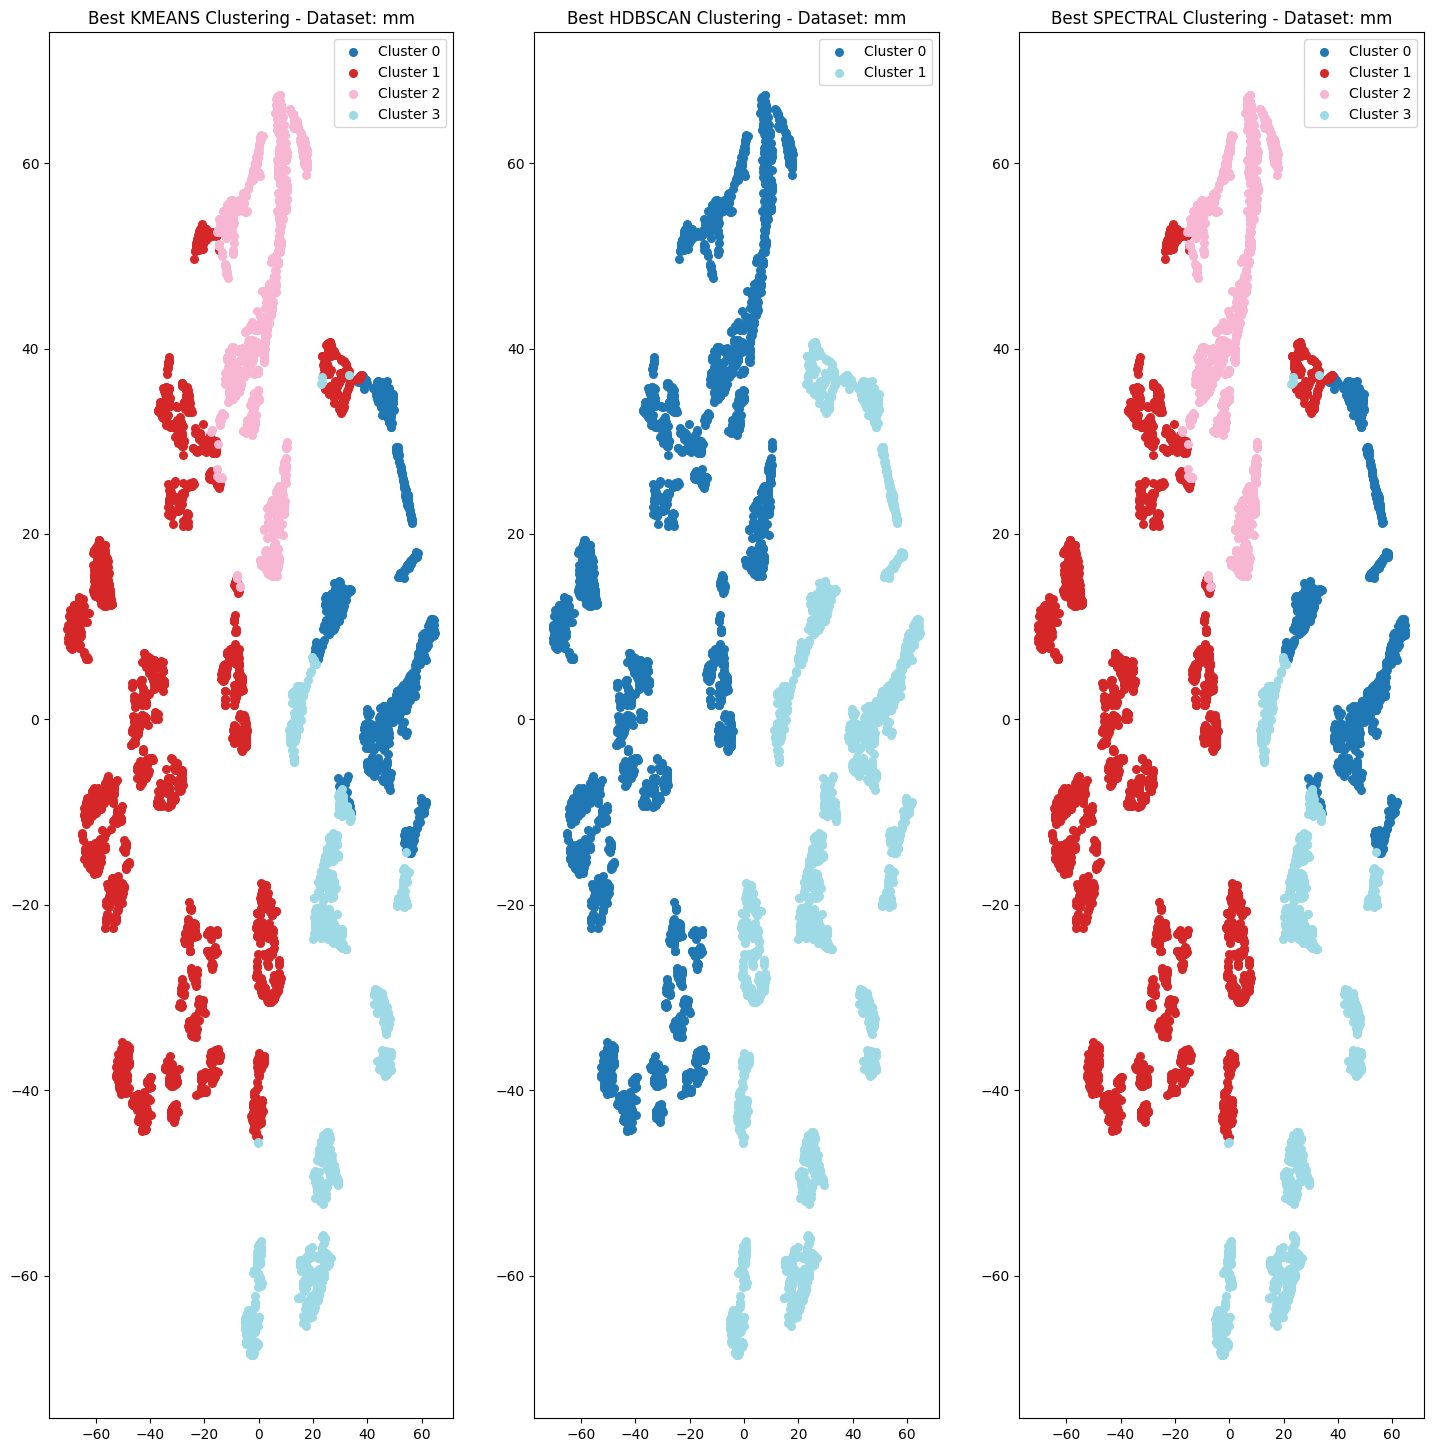

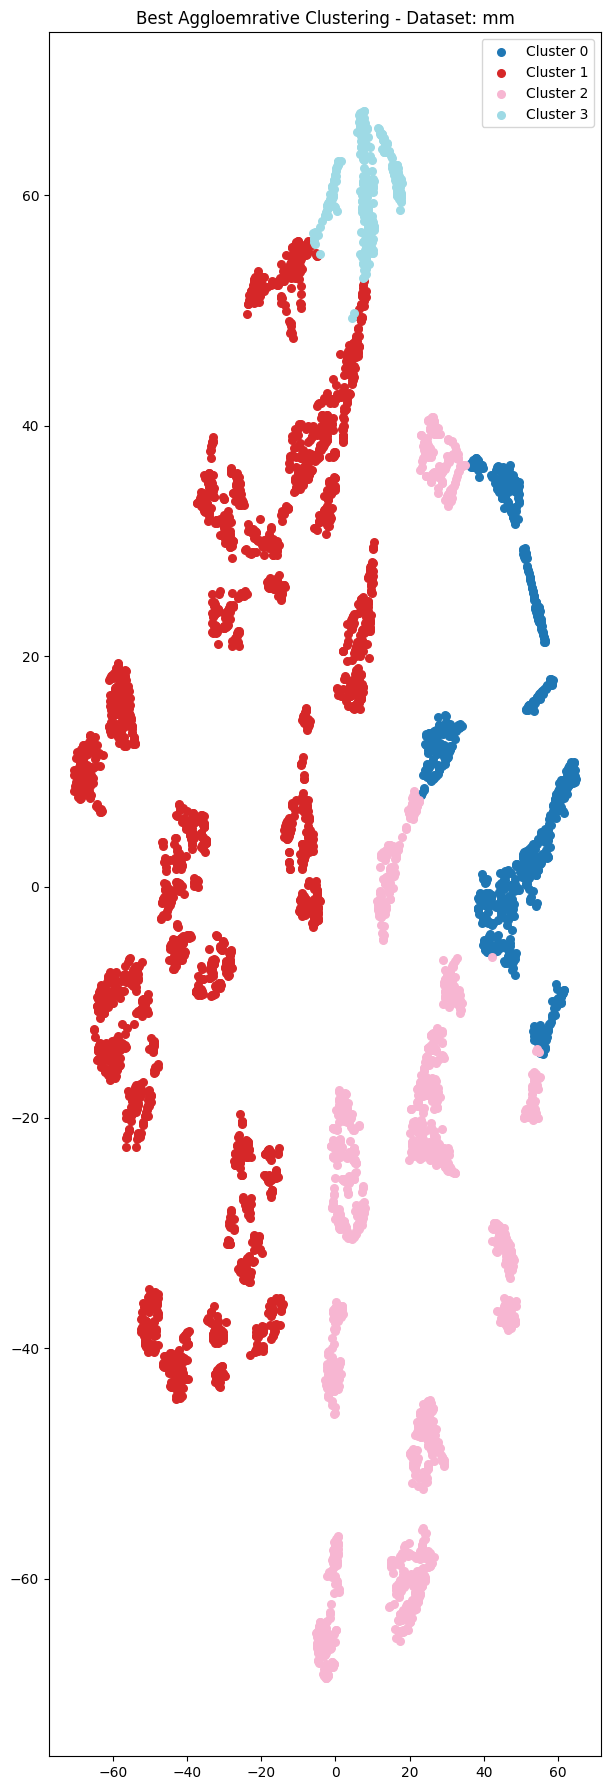

In [116]:
latent_late_fusion = Concatenate()([latent_ts, latent_st])
latent_late_fusion = np.array(latent_late_fusion)
data = [latent_mm]
#latent_st, latent_ts,latent_mm, latent_late_fusion
dataset_name = ['mm']
#'st', 'ts','mm', 'lf'

results = pd.DataFrame()
best_labels = pd.DataFrame()
all_labels = pd.DataFrame()
for i, y in zip(data, dataset_name):
    df_results, best_labels_, labels_df, best_model = clustering_helpers.compare_kmeans_hdbscan(i, dataset_name = y,  max_k=12)
    #
    df_results.index = [y, y, y, y]

    y = f'{y}_{best_model}'
    labels_ = pd.Series(best_labels_, name=y)
    best_labels = pd.concat([best_labels, labels_], axis=1)
    all_labels = pd.concat([all_labels, labels_df], axis=1)
    
    #results = results.append(df_results)
    results = pd.concat([results, df_results])

In [114]:
results

,Model,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
mm,KMeans,0.480549,0.780216,6838.973233
mm,HDBSCAN,0.490179,1.536594,6419.689956
mm,Spectral,0.480549,0.780216,6838.973233
mm,Agglomerative,0.437659,0.811178,4939.099636


## Cluster Stability

In [12]:
best_labels.columns

Index(['mm_HDBSCAN'], dtype='object')

In [13]:
all_labels.columns

Index(['mm_KMeans', 'mm_Spectral', 'mm_HDBSCAN', 'mm_Agglomerative'], dtype='object')

In [ ]:
plt.style.use('default')
# Perform cluster stability analysis using Spectral
labels_ = ['mm_HDBSCAN']
jaccard_indices_mm = clustering_helpers.cluster_stability(latent_mm, all_labels[labels_][labels_[0]].values, 7, 'hdbscan', num_iterations=100)
mean_jaccard_mm = np.mean(jaccard_indices_mm)

labels_ = ['lf_KMeans']
# Perform cluster stability analysis using KMeans
jaccard_indices_lf = clustering_helpers.cluster_stability(latent_late_fusion, all_labels[labels_][labels_[0]].values, 5, 'kmeans', num_iterations=100)
mean_jaccard_lf = np.mean(jaccard_indices_lf)

# Plotting ARI and Jaccard Index across the runs
plt.figure(figsize=(6, 6))
plt.plot(range(1, len(jaccard_indices_mm) + 1), jaccard_indices_mm, label="Jaccard Index MM, mean: {0:.2}".format(mean_jaccard_mm), marker='o')
plt.plot(range(1, len(jaccard_indices_lf) + 1), jaccard_indices_lf, label="Jaccard Index LF, mean: {0:.2}".format(mean_jaccard_lf) , marker='o')
plt.xlabel("Bootstrap Iteration")
plt.ylabel("Index Value")
plt.legend()
plt.tight_layout()

plt.show()

## KM

In [15]:
sepsis3.columns

Index(['icustay_id', 'hadm_id', 'excluded', 'intime', 'outtime', 'dbsource',
       'suspected_infection_time_poe', 'suspected_infection_time_poe_days',
       'specimen_poe', 'positiveculture_poe', 'antibiotic_time_poe',
       'blood_culture_time', 'blood_culture_positive', 'age', 'gender',
       'is_male', 'ethnicity', 'race_white', 'race_black', 'race_hispanic',
       'race_other', 'metastatic_cancer', 'diabetes', 'height', 'weight',
       'bmi', 'first_service', 'hospital_expire_flag', 'thirtyday_expire_flag',
       'icu_los', 'hosp_los', 'sepsis_angus', 'sepsis_martin',
       'sepsis_explicit', 'septic_shock_explicit', 'severe_sepsis_explicit',
       'sepsis_nqf', 'sepsis_cdc', 'sepsis_cdc_simple', 'elixhauser_hospital',
       'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'composite_outcome',
       'blood culture', 'suspicion_poe', 'abx_poe', 'sepsis-3', 'sofa>=2'],
      dtype='object')

In [16]:
best_labels.columns

Index(['mm_HDBSCAN'], dtype='object')

mm_HDBSCAN  thirtyday_expire_flag
-1          0                        152
            1                         17
 0          0                        194
            1                        106
 1          0                        441
            1                        118
 2          0                        409
            1                        133
 3          0                        460
            1                        106
 4          0                        501
            1                         91
 5          0                        144
            1                        101
 6          0                        154
            1                         13
 7          0                        213
            1                         14
 8          0                        192
            1                        101
 9          0                        181
            1                         50
 10         0                        343
            1          

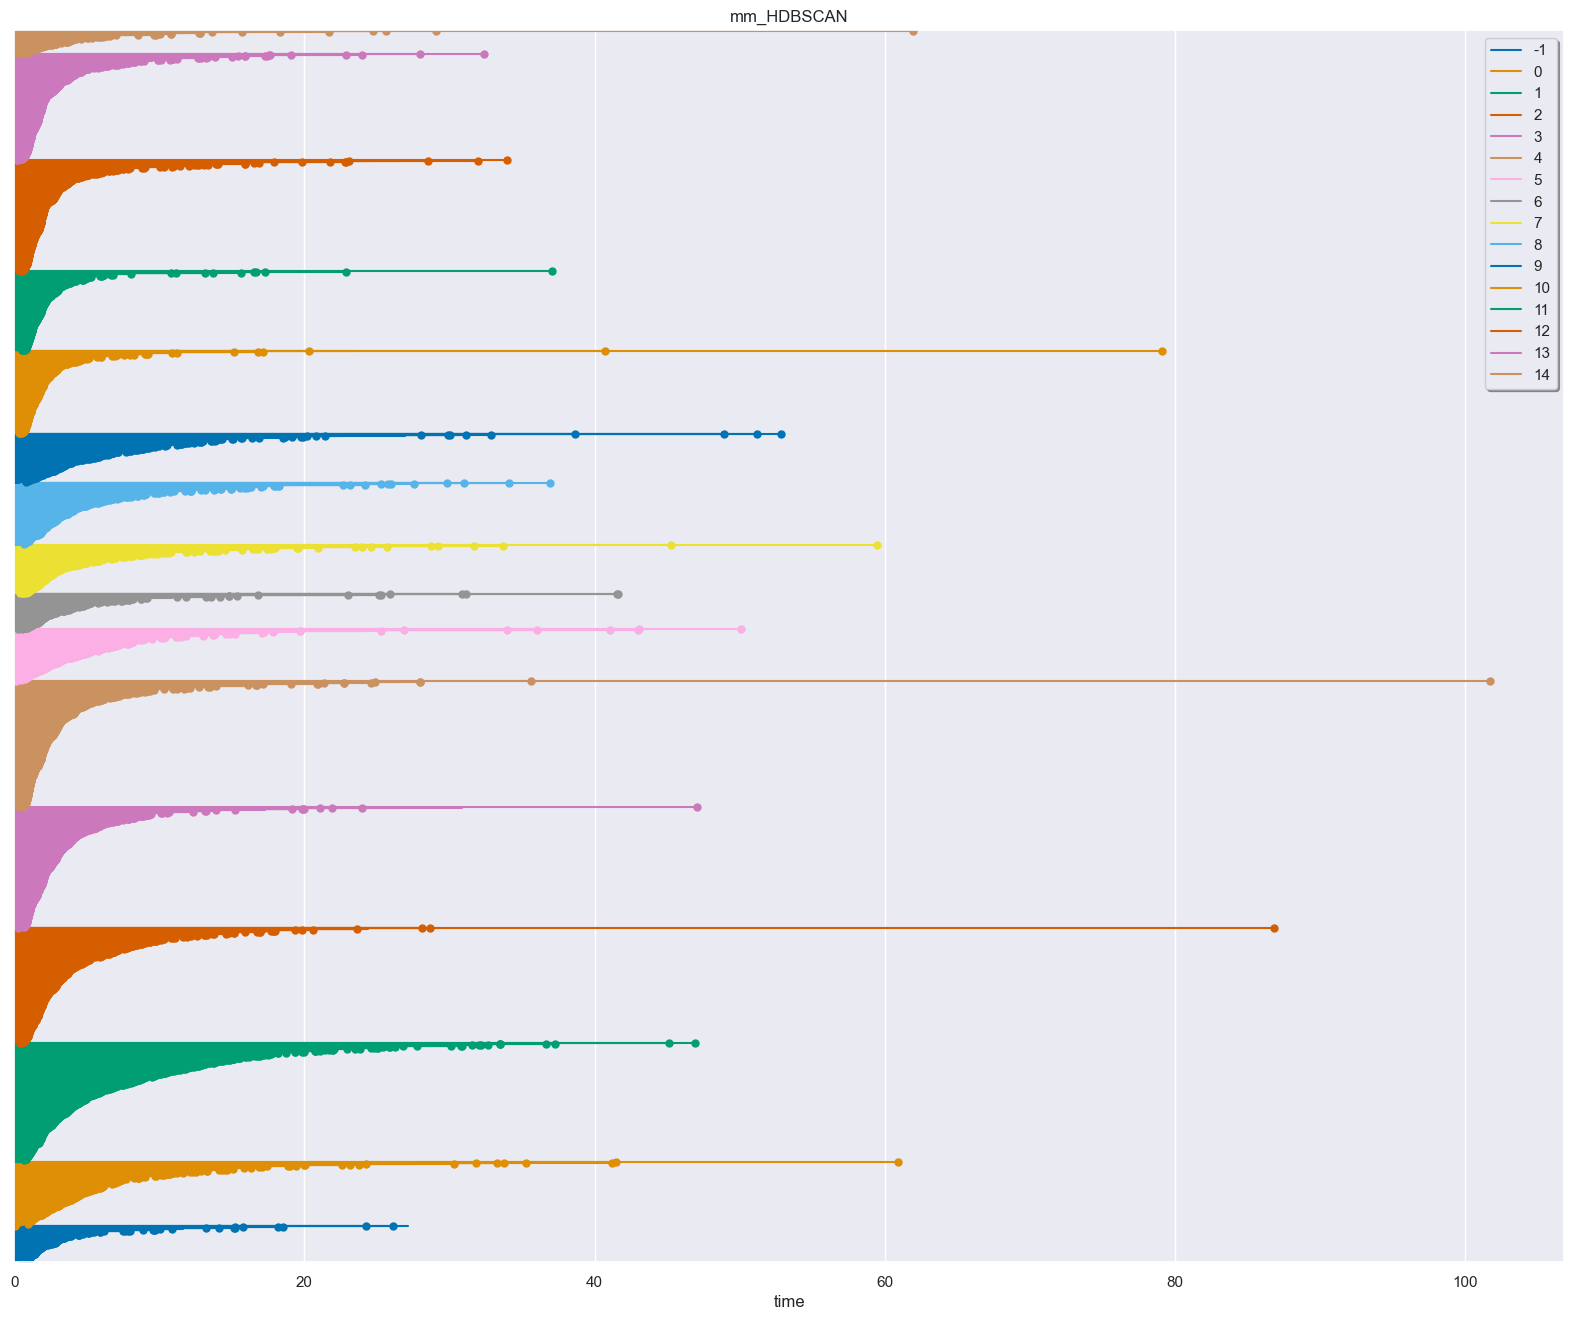

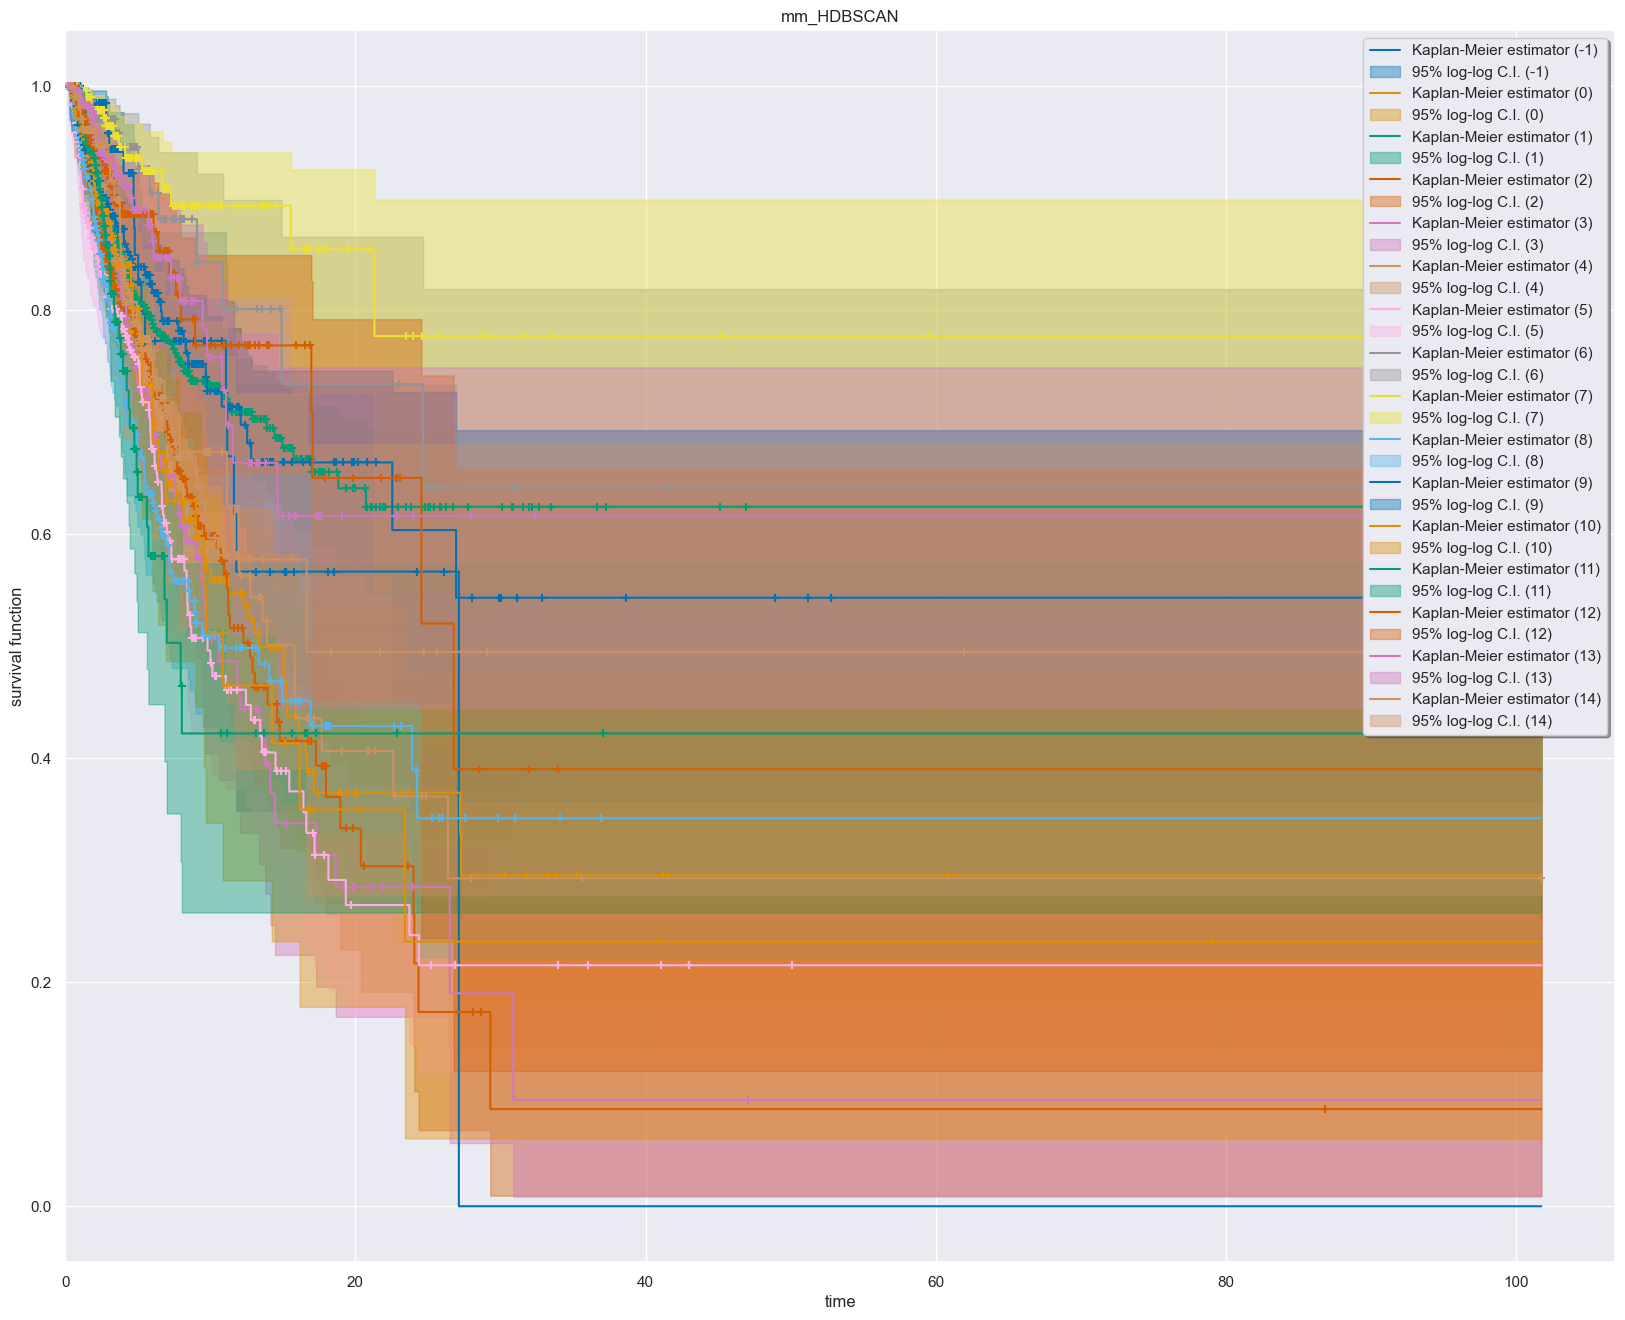

mm_HDBSCAN


group,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
time,,,,,,,,,,,,,,,,
1,1.000000,0.953084,0.962136,0.963969,0.981577,0.976965,0.937701,0.993631,0.995516,0.955340,0.965291,0.973087,0.994273,0.983633,0.993600,0.981299
3,0.958394,0.843443,0.880882,0.839315,0.870776,0.881733,0.811417,0.970539,0.964081,0.808852,0.895106,0.878055,0.858128,0.924353,0.934772,0.931228
5,0.849398,0.738146,0.805022,0.778196,0.735880,0.789038,0.758566,0.945455,0.936120,0.675380,0.838876,0.801304,0.655851,0.886122,0.889487,0.786255
10,0.772699,0.567866,0.732020,0.598403,0.506661,0.596910,0.496160,0.842977,0.893409,0.510337,0.727700,0.511561,0.422157,0.768577,0.757943,0.673741
30,0.000000,0.295428,0.624613,0.086734,0.190067,0.292721,0.215148,0.642331,0.776877,0.346476,0.543356,0.236219,0.422157,0.390201,0.616487,0.494994


In [16]:
labels_ = ['mm_HDBSCAN']


sns.set(style="darkgrid", palette="colorblind", color_codes=True)



for modality in labels_:
    kmd = sepsis3.join(all_labels[modality])
    surv = SurvivalData(time="icu_los", status="thirtyday_expire_flag", group=modality, data=kmd)
    print(kmd.groupby(modality)['thirtyday_expire_flag'].value_counts())

    #observed lifetimes of all the individuals in the data. Censored individuals are marked at the end of their lifespan.
    plt.figure(figsize=(20, 16))
    surv.plot_lifetimes()
    plt.title(modality)
    plt.show()
    plt.close()

    #kaplan meier
    km = KaplanMeier()
    km.fit(surv)

    #display(km.summary())
    # abulates the survival probability estimates and thier 
    # standard error and confidence intervals for the event times within each group. 
    # It can be printed to display all the information at once.
    #print(km.summary)
    plt.figure(figsize=(20, 16))
    km.plot()
    plt.title(modality)
    plt.show()
    plt.close()


    estimate = km.predict([1, 3, 5, 10, 30])
    # estimated probabiltiies for surviving past a certain time for each group.
    print(modality)
    display(estimate)

## Table1

In [23]:
from tableone import TableOne

ts_2d_df = pd.read_csv('preprocessing/representations/time_series_2d.csv')
ts_2d_df = ts_2d_df.set_index('icustay_id')


hd_labels = all_labels[labels_]
hd_labels.index = ts_2d_df.index

temp = ts_2d_df.join(hd_labels)

table1 = TableOne(temp, dip_test=True, normal_test=True, tukey_test=True)
table1

/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


,,Missing,Overall
n,,,5784
"hours_in, n (%)",11.5,0,5784 (100.0)
"aado2, mean (SD)",,4940,441.2 (133.6)
"baseexcess, mean (SD)",,1950,-1.7 (8.4)
"bicarbonate, mean (SD)",,13,23.2 (4.5)
"totalco2, mean (SD)",,1951,24.4 (5.6)
"carboxyhemoglobin, mean (SD)",,5596,2.2 (1.5)
"chloride, mean (SD)",,13,104.9 (6.2)
"calcium, mean (SD)",,3085,1.1 (0.1)
"glucose, mean (SD)",,3,164.0 (1461.9)


In [24]:
nonnormal = list(temp.columns)

In [25]:
table2 = TableOne(temp, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)

table2

/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWa

Grouped by mm_HDBSCAN                                                                                                                                                                                                                                                                                                                                                                                                        
                                                       Missing              Overall                   -1                    0                    1                   10                   11                   12                   13                   14                    2                    3                    4                    5                    6                    7                    8                    9 P-Value (adjusted)            Test
n                                                                              5784                  169                  300                  559                  390                  372                  522                  499                  110                  542                  566                  592                  245                  167                  227                  293                  231                                   
hours_in, median [Q1,Q3]            11.5                     0         5784 (100.0)          169 (100.0)          300 (100.0)          559 (100.0)          390 (100.0)          372 (100.0)          522 (100.0)          499 (100.0)          110 (100.0)          542 (100.0)          566 (100.0)          592 (100.0)          245 (100.0)          167 (100.0)          227 (100.0)          293 (100.0)          231 (100.0)              1.000     Chi-squared
aado2, median [Q1,Q3]                                     4940  459.0 [341.0,556.8]  534.5 [422.0,581.0]  478.0 [413.5,556.6]  475.5 [352.5,558.1]  498.0 [437.0,546.0]  460.0 [378.2,571.8]  519.0 [405.5,575.0]  437.0 [284.0,532.0]  554.0 [433.5,570.1]  431.0 [329.5,517.2]  523.5 [360.2,594.5]  510.0 [441.0,611.1]  436.5 [311.0,510.0]  398.0 [317.2,519.9]  395.0 [300.0,539.2]  424.0 [298.5,539.6]  450.5 [342.5,527.1]              0.007  Kruskal-Wallis
baseexcess, median [Q1,Q3]                                1950      -1.0 [-4.0,1.0]      -0.5 [-2.9,0.7]      -1.5 [-5.0,0.4]      -1.0 [-4.1,1.0]      -1.0 [-4.0,1.0]      -0.5 [-3.0,1.0]      -1.0 [-5.0,1.0]      -1.0 [-3.5,1.0]      -1.0 [-5.0,2.0]      -0.5 [-3.4,1.2]      -0.6 [-3.6,2.0]       0.0 [-3.2,2.0]      -1.2 [-5.2,1.0]      -1.5 [-4.5,0.4]      -1.0 [-3.5,0.8]      -1.3 [-4.8,0.5]      -1.4 [-5.6,1.0]              0.015  Kruskal-Wallis
bicarbonate, median [Q1,Q3]                                 13     23.3 [20.5,26.0]     24.2 [21.8,26.0]     22.7 [20.0,25.2]     23.5 [20.6,25.7]     23.0 [20.8,25.0]     23.3 [21.0,25.3]     23.0 [19.8,25.0]     23.5 [21.0,25.7]     22.0 [20.0,25.5]     23.5 [20.5,26.4]     24.0 [21.2,26.5]     23.7 [21.0,26.7]     23.0 [19.5,26.3]     23.3 [20.6,25.6]     23.5 [21.0,25.5]     22.5 [20.0,25.3]     22.0 [19.2,24.9]             <0.001  Kruskal-Wallis
totalco2, median [Q1,Q3]                                  1951     24.2 [21.0,27.2]     24.7 [22.0,27.3]     23.8 [20.7,26.6]     24.5 [21.8,27.4]     24.0 [21.0,26.0]     24.7 [22.0,27.0]     24.0 [20.0,27.0]     24.2 [21.1,27.0]     24.0 [21.0,28.5]     24.6 [21.0,28.0]     25.0 [21.7,28.6]     25.0 [22.0,28.0]     23.8 [19.8,27.2]     24.0 [21.0,27.0]     24.5 [22.0,27.0]     23.7 [20.8,26.8]     23.7 [20.3,26.6]              0.015  Kruskal-Wallis
carboxyhemoglobin, median [Q1,Q3]                         5596        2.0 [1.0,2.6]        2.5 [1.9,4.1]        2.0 [1.0,2.0]        2.0 [1.2,2.0]        2.0 [2.0,2.8]        2.0 [1.0,2.3]        2.0 [2.0,3.1]        2.0 [1.0,3.0]        2.0 [1.8,3.2]        2.0 [1.6,3.0]        2.0 [1.8,2.2]        1.0 [1.0,2.5]        2.0 [1.2,2.5]        2.0 [1.2,2.0]        2.0 [1.0,3.9]        2.0 [1.2,2.0]   

In [26]:
t2 = table2.tableone
t2.columns = t2.columns.droplevel()
t2 = t2.replace(to_replace='<', value='', regex=True)

t2["P-Value (adjusted)"] = pd.to_numeric(t2["P-Value (adjusted)"], errors='coerce', downcast="float")

t2[t2['P-Value (adjusted)']<=0.05]

,,Missing,Overall,-1,0,1,10,11,12,13,14,2,3,4,5,6,7,8,9,P-Value (adjusted),Test
"aado2, median [Q1,Q3]",,4940,"459.0 [341.0,556.8]","534.5 [422.0,581.0]","478.0 [413.5,556.6]","475.5 [352.5,558.1]","498.0 [437.0,546.0]","460.0 [378.2,571.8]","519.0 [405.5,575.0]","437.0 [284.0,532.0]","554.0 [433.5,570.1]","431.0 [329.5,517.2]","523.5 [360.2,594.5]","510.0 [441.0,611.1]","436.5 [311.0,510.0]","398.0 [317.2,519.9]","395.0 [300.0,539.2]","424.0 [298.5,539.6]","450.5 [342.5,527.1]",0.007,Kruskal-Wallis
"baseexcess, median [Q1,Q3]",,1950,"-1.0 [-4.0,1.0]","-0.5 [-2.9,0.7]","-1.5 [-5.0,0.4]","-1.0 [-4.1,1.0]","-1.0 [-4.0,1.0]","-0.5 [-3.0,1.0]","-1.0 [-5.0,1.0]","-1.0 [-3.5,1.0]","-1.0 [-5.0,2.0]","-0.5 [-3.4,1.2]","-0.6 [-3.6,2.0]","0.0 [-3.2,2.0]","-1.2 [-5.2,1.0]","-1.5 [-4.5,0.4]","-1.0 [-3.5,0.8]","-1.3 [-4.8,0.5]","-1.4 [-5.6,1.0]",0.015,Kruskal-Wallis
"bicarbonate, median [Q1,Q3]",,13,"23.3 [20.5,26.0]","24.2 [21.8,26.0]","22.7 [20.0,25.2]","23.5 [20.6,25.7]","23.0 [20.8,25.0]","23.3 [21.0,25.3]","23.0 [19.8,25.0]","23.5 [21.0,25.7]","22.0 [20.0,25.5]","23.5 [20.5,26.4]","24.0 [21.2,26.5]","23.7 [21.0,26.7]","23.0 [19.5,26.3]","23.3 [20.6,25.6]","23.5 [21.0,25.5]","22.5 [20.0,25.3]","22.0 [19.2,24.9]",0.001,Kruskal-Wallis
"totalco2, median [Q1,Q3]",,1951,"24.2 [21.0,27.2]","24.7 [22.0,27.3]","23.8 [20.7,26.6]","24.5 [21.8,27.4]","24.0 [21.0,26.0]","24.7 [22.0,27.0]","24.0 [20.0,27.0]","24.2 [21.1,27.0]","24.0 [21.0,28.5]","24.6 [21.0,28.0]","25.0 [21.7,28.6]","25.0 [22.0,28.0]","23.8 [19.8,27.2]","24.0 [21.0,27.0]","24.5 [22.0,27.0]","23.7 [20.8,26.8]","23.7 [20.3,26.6]",0.015,Kruskal-Wallis
"chloride, median [Q1,Q3]",,13,"105.0 [101.5,108.5]","105.0 [101.5,107.0]","105.9 [103.0,108.5]","105.7 [102.0,108.5]","105.5 [102.0,108.5]","105.0 [101.5,108.0]","105.5 [101.3,108.5]","104.0 [100.3,107.3]","101.0 [97.1,106.0]","106.0 [102.0,109.5]","104.0 [100.0,107.3]","104.0 [100.9,107.5]","106.0 [101.3,109.5]","106.0 [102.3,109.9]","105.5 [102.1,108.3]","106.6 [103.5,110.4]","107.0 [103.4,110.0]",0.001,Kruskal-Wallis
"calcium, median [Q1,Q3]",,3085,"1.1 [1.1,1.1]","1.1 [1.1,1.1]","1.1 [1.1,1.2]","1.1 [1.1,1.1]","1.1 [1.0,1.1]","1.1 [1.1,1.1]","1.1 [1.0,1.1]","1.1 [1.0,1.1]","1.1 [1.0,1.1]","1.1 [1.1,1.2]","1.1 [1.1,1.2]","1.1 [1.1,1.2]","1.1 [1.1,1.1]","1.1 [1.0,1.2]","1.1 [1.1,1.1]","1.1 [1.1,1.1]","1.1 [1.0,1.1]",0.001,Kruskal-Wallis
"glucose, median [Q1,Q3]",,3,"133.0 [112.4,162.7]","120.3 [107.6,140.5]","139.9 [118.4,172.9]","134.9 [117.9,170.8]","128.0 [109.3,154.5]","131.6 [112.0,159.5]","125.0 [105.1,154.0]","126.0 [106.6,157.0]","130.7 [108.0,162.2]","137.0 [117.8,172.3]","135.0 [113.3,162.6]","133.4 [111.3,160.1]","144.9 [120.4,177.2]","133.9 [108.0,160.5]","133.4 [109.9,149.9]","144.0 [120.0,178.0]","140.0 [120.0,177.4]",0.001,Kruskal-Wallis
"hematocrit, median [Q1,Q3]",,21,"32.3 [28.7,36.4]","33.6 [29.4,36.8]","31.9 [29.4,37.3]","34.7 [30.3,39.3]","31.0 [27.8,34.6]","32.5 [29.0,36.5]","31.2 [27.5,34.9]","32.9 [28.6,37.3]","31.8 [27.0,36.1]","32.2 [29.0,35.8]","31.7 [28.5,35.1]","32.1 [28.2,36.4]","31.9 [29.1,35.5]","32.9 [28.4,35.9]","34.0 [28.8,39.3]","32.4 [29.3,36.1]","33.0 [29.3,36.4]",0.001,Kruskal-Wallis
"hemoglobin, median [Q1,Q3]",,24,"10.9 [9.6,12.3]","11.6 [9.8,12.7]","10.9 [9.8,12.4]","11.8 [10.3,13.5]","10.3 [9.3,11.7]","11.0 [9.8,12.4]","10.5 [9.2,11.8]","11.3 [9.6,12.8]","10.4 [9.0,12.5]","10.8 [9.5,11.9]","10.6 [9.4,11.6]","10.7 [9.4,12.2]","10.6 [9.6,11.8]","11.0 [9.5,12.2]","11.8 [9.8,13.4]","10.8 [9.8,12.0]","11.1 [9.8,12.1]",0.001,Kruskal-Wallis
"lactate, median [Q1,Q3]",,1140,"1.9 [1.3,2.7]","1.8 [1.3,2.6]","2.0 [1.4,3.1]","2.1 [1.5,3.4]","1.7 [1.2,2.5]","1.8 [1.4,2.5]","1.7 [1.2,2.5]","1.8 [1.3,2.4]","1.8 [1.4,2.7]","1.8 [1.3,2.7]","1.8 [1.3,2.4]","1.8 [1.3,2.4]","1.9 [1.4,2.8]","1.7 [1.2,2.6]","1.9 [1.4,2.8]","2.0 [1.4,3.1]","2.0 [1.4,3.1]",0.001,Kruskal-Wallis


In [27]:
#static = static.set_index('icustay_id')
temp = static.join(hd_labels)


table = TableOne(temp, groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
                  htest_name=True, display_all=True)
table 

/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWa

Grouped by mm_HDBSCAN                                                                                                                                                                                                                                                            
                                                           Missing      Overall          -1            0            1           10           11           12           13           14            2            3            4            5            6            7            8            9 P-Value (adjusted)         Test
n                                                                          5784         169          300          559          390          372          522          499          110          542          566          592          245          167          227          293          231                                
vent, n (%)                              0.0                     0  3002 (51.9)  106 (62.7)     24 (8.0)     34 (6.1)   320 (82.1)   297 (79.8)   404 (77.4)   370 (74.1)    85 (77.3)   231 (42.6)   439 (77.6)   465 (78.5)    54 (22.0)    39 (23.4)    65 (28.6)    52 (17.7)     17 (7.4)             <0.001  Chi-squared
                                         1.0                        2782 (48.1)   63 (37.3)   276 (92.0)   525 (93.9)    70 (17.9)    75 (20.2)   118 (22.6)   129 (25.9)    25 (22.7)   311 (57.4)   127 (22.4)   127 (21.5)   191 (78.0)   128 (76.6)   162 (71.4)   241 (82.3)   214 (92.6)                                
F, n (%)                                 0.0                     0  3221 (55.7)  148 (87.6)  300 (100.0)  559 (100.0)      1 (0.3)  372 (100.0)               499 (100.0)  110 (100.0)   248 (45.8)               592 (100.0)      1 (0.4)    17 (10.2)   225 (99.1)   149 (50.9)                          <0.001  Chi-squared
                                         1.0                        2563 (44.3)   21 (12.4)                             389 (99.7)               522 (100.0)                             294 (54.2)  566 (100.0)                244 (99.6)   150 (89.8)      2 (0.9)   144 (49.1)  231 (100.0)                                
M, n (%)                                 0.0                     0  2563 (44.3)   21 (12.4)                             389 (99.7)               522 (100.0)                             294 (54.2)  566 (100.0)                244 (99.6)   150 (89.8)      2 (0.9)   144 (49.1)  231 (100.0)             <0.001  Chi-squared
                                         1.0                        3221 (55.7)  148 (87.6)  300 (100.0)  559 (100.0)      1 (0.3)  372 (100.0)               499 (100.0)  110 (100.0)   248 (45.8)               592 (100.0)      1 (0.4)    17 (10.2)   225 (99.1)   149 (50.9)                                             
adults, n (%)                            0.0                     0  3407 (58.9)   45 (26.6)  300 (100.0)     38 (6.8)  390 (100.0)  372 (100.0)                   4 (0.8)               542 (100.0)  566 (100.0)  592 (100.0)  245 (100.0)    17 (10.2)      3 (1.3)  293 (100.0)                          <0.001  Chi-squared
                                         1.0                        2377 (41.1)  124 (73.4)                521 (93.2)                            522 (100.0)   495 (99.2)  110 (100.0)                                                       150 (89.8)   224 (98.7)               231 (100.0)                                
seniors, n (%)                           0.0                     0  2531 (43.8)  168 (99.4)               559 (100.0)     37 (9.5)               522 (100.0)  499 (100.0)  110 (100.0)      1 (0.2)                                         167 (100.0)  227 (100.0)     10 (3.4)  231 (100.0)             <0.001  Chi-squared
                                         1.0                        3253 (56.2)     1 (0.6)  300 (100.0)                353 (90.5)  372 (100.0)                                          541 (99.8)  566 (100.0)  592 (10

In [46]:
hd_labels.value_counts()

mm_HDBSCAN
 4            592
 3            566
 1            559
 2            542
 12           522
 13           499
 10           390
 11           372
 0            300
 8            293
 5            245
 9            231
 7            227
-1            169
 6            167
 14           110
dtype: int64

## Spider Plots

In [64]:
def create_spider_plot(categories, values, cluster_names):
    """
    Create a spider plot to visualize cluster counts for different variables.

    Parameters:
    - categories (list): List of variable categories.
    - values (list of arrays): Cluster values for each category.
    - cluster_names (list): Names for different clusters.

    Returns:
    None

    Example:
    create_spider_plot(
        categories=['Category1', 'Category2', 'Category3'],
        values=[[10, 15, 20], [5, 10, 15]],
        cluster_names=['Cluster A', 'Cluster B']
    )
    """
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    values = np.array(values)
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
    plt.xticks(angles, categories)

    for i, (cluster_name, cluster_values) in enumerate(zip(cluster_names, values)):
        ax.plot(angles, cluster_values, label=cluster_name)
        ax.fill(angles, cluster_values, alpha=0.25)

    ax.set_yticklabels([])
    ax.legend()
    plt.title("Cluster Counts for Each Variable")
    plt.show()


In [61]:
static.join(best_labels[labels_]).groupby(labels_).sum()


,vent,F,M,adults,seniors,race_white,race_other,gcs_13_15,gcs_9_12,gcs_<8,...,alcohol_abuse,depression,diabetes,circulatory,circulatory_infectious_congenital,nervous_and_sense,endocrinal_nutritional,neoplasms,blood_and_blood_forming,mental
mm_HDBSCAN,,,,,,,,,,,,,,,,,,,,,
-1,63,21,148,124,1,124,24,148,10,11,...,45,19,16,110,11,27,39,10,59,21
0,276,0,300,0,300,230,52,0,0,300,...,17,24,108,300,79,65,219,27,72,26
1,525,0,559,521,0,378,116,0,0,559,...,119,67,115,197,47,166,357,57,111,82
2,311,294,248,0,541,403,83,0,542,0,...,24,76,176,339,110,109,410,82,103,91
3,127,566,0,0,566,455,58,566,0,0,...,6,82,194,566,164,63,438,61,109,90
4,127,0,592,0,592,490,54,592,0,0,...,28,51,224,592,183,74,411,88,139,56
5,191,244,1,0,245,162,58,0,0,245,...,6,38,89,244,72,59,192,18,57,42
6,128,150,17,150,0,103,32,0,167,0,...,21,30,32,48,12,40,106,14,34,35
7,162,2,225,224,0,151,49,0,227,0,...,70,30,54,61,14,57,132,27,50,37


In [ ]:
# Female: 10, 12, 3, 5, 6, 9 
# Male: 0, 1, 11, 13, 14, 4, 7 
# Mix:  2, 6, 8

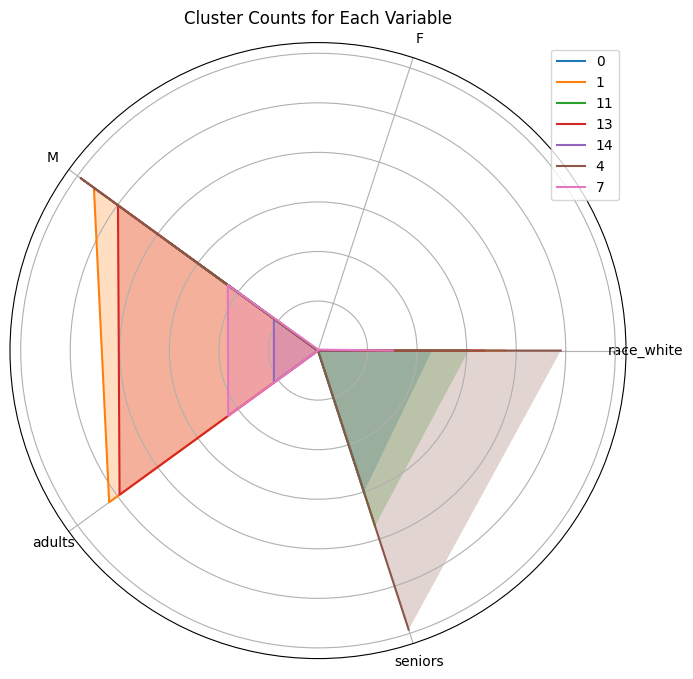

In [104]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['race_white', 'F', 'M', 'adults', 'seniors']]
#iloc[[3,4,9,10], :]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

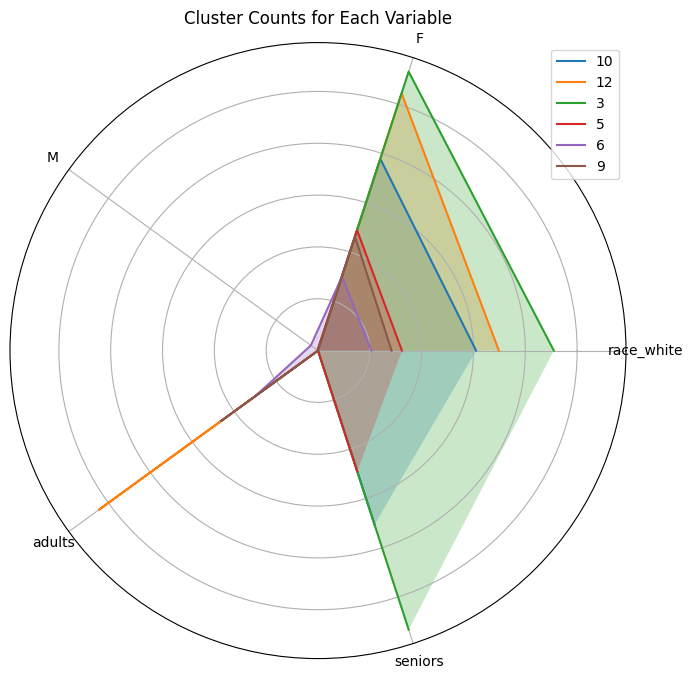

In [94]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[11, 13, 4, 6, 7, 10 ], :][['race_white', 'F', 'M', 'adults', 'seniors']]
#iloc[[3,4,9,10], :]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

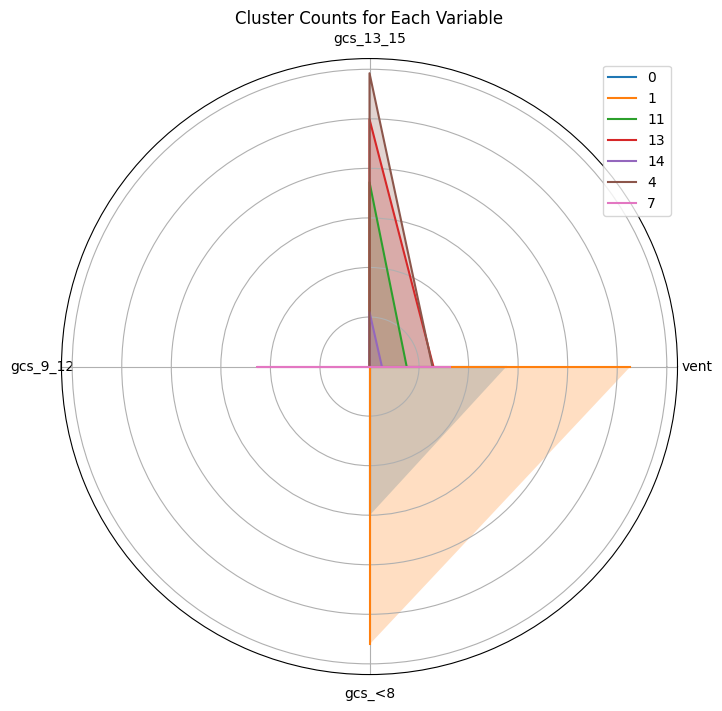

In [105]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['vent', 'gcs_13_15', 'gcs_9_12',
       'gcs_<8']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

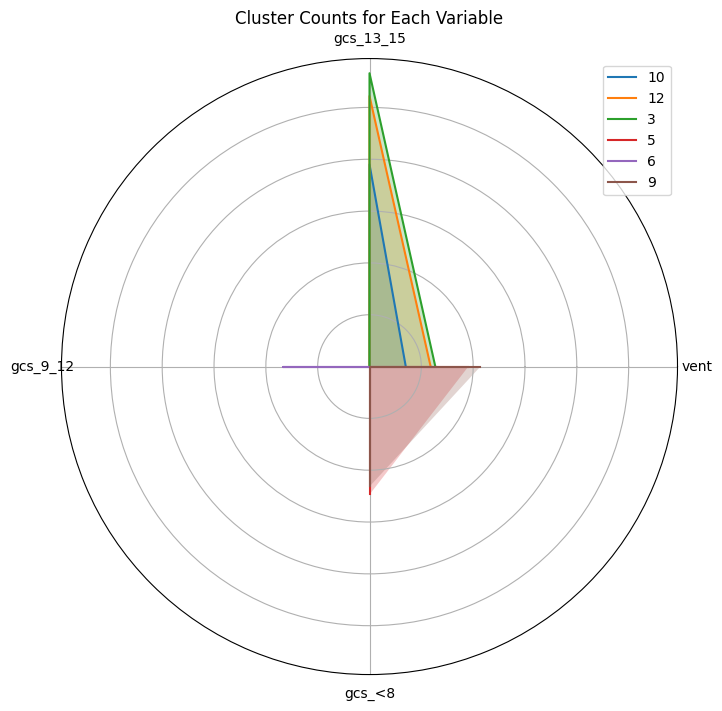

In [95]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[11, 13, 4, 6, 7, 10 ], :][['vent', 'gcs_13_15', 'gcs_9_12',
       'gcs_<8']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

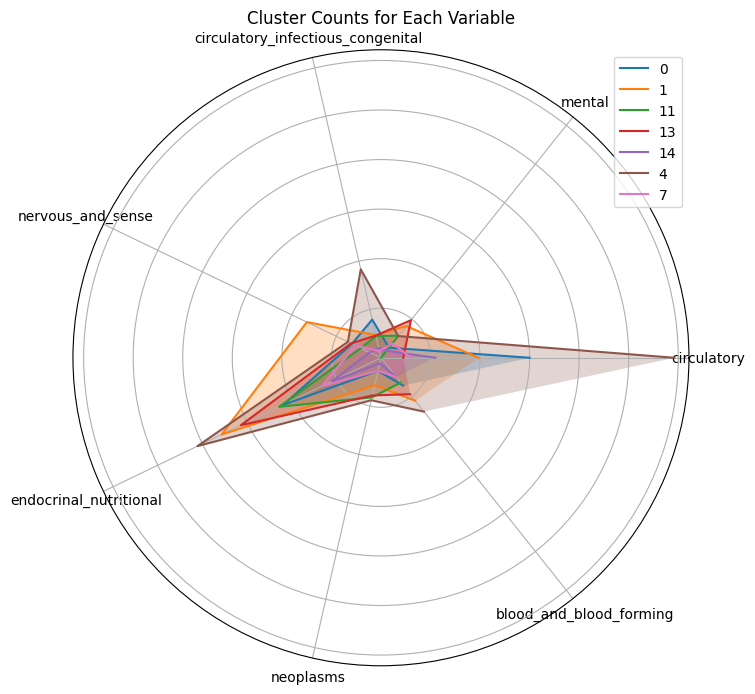

In [106]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['circulatory', 'mental', 'circulatory_infectious_congenital',
       'nervous_and_sense', 'endocrinal_nutritional', 'neoplasms',
       'blood_and_blood_forming']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

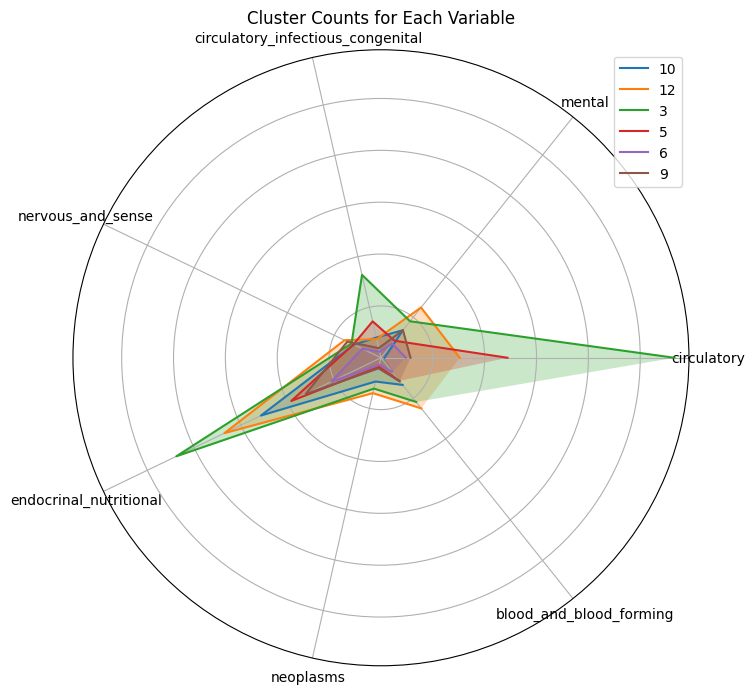

In [96]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[11, 13, 4, 6, 7, 10 ], :][['circulatory', 'mental', 'circulatory_infectious_congenital',
       'nervous_and_sense', 'endocrinal_nutritional', 'neoplasms',
       'blood_and_blood_forming']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [72]:
static.columns

Index(['vent', 'F', 'M', 'adults', 'seniors', 'race_white', 'race_other',
       'gcs_13_15', 'gcs_9_12', 'gcs_<8', 'congestive_heart_failure',
       'cardiac_arrhythmias', 'hypertension', 'other_neurological',
       'chronic_pulmonary', 'hypothyroidism', 'renal_failure', 'liver_disease',
       'coagulopathy', 'fluid_electrolyte', 'alcohol_abuse', 'depression',
       'diabetes', 'circulatory', 'circulatory_infectious_congenital',
       'nervous_and_sense', 'endocrinal_nutritional', 'neoplasms',
       'blood_and_blood_forming', 'mental'],
      dtype='object')

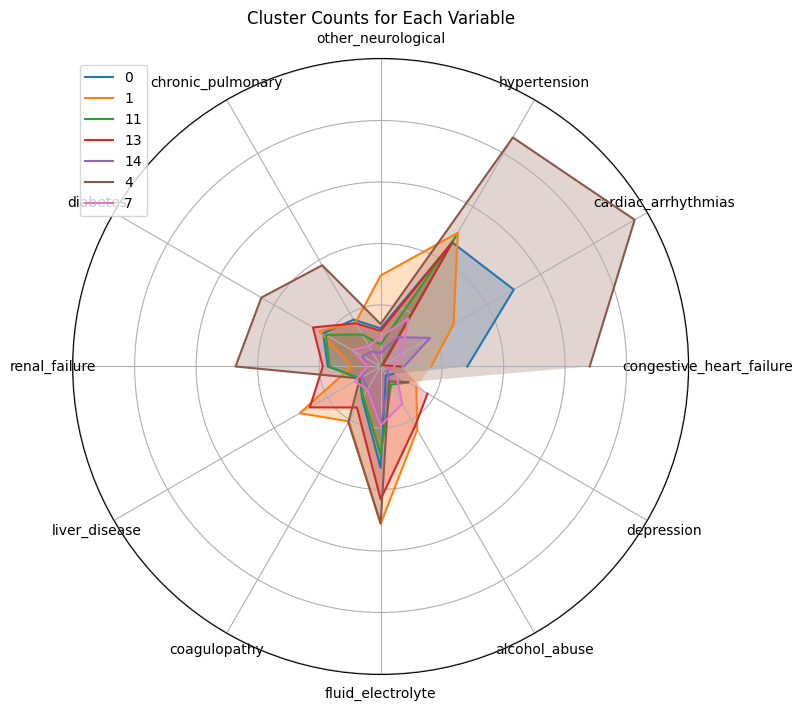

In [107]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['congestive_heart_failure', 'cardiac_arrhythmias', 
        'hypertension', 'other_neurological',
       'chronic_pulmonary', 'diabetes', 'renal_failure',
       'liver_disease', 'coagulopathy', 'fluid_electrolyte',
       'alcohol_abuse', 'depression']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

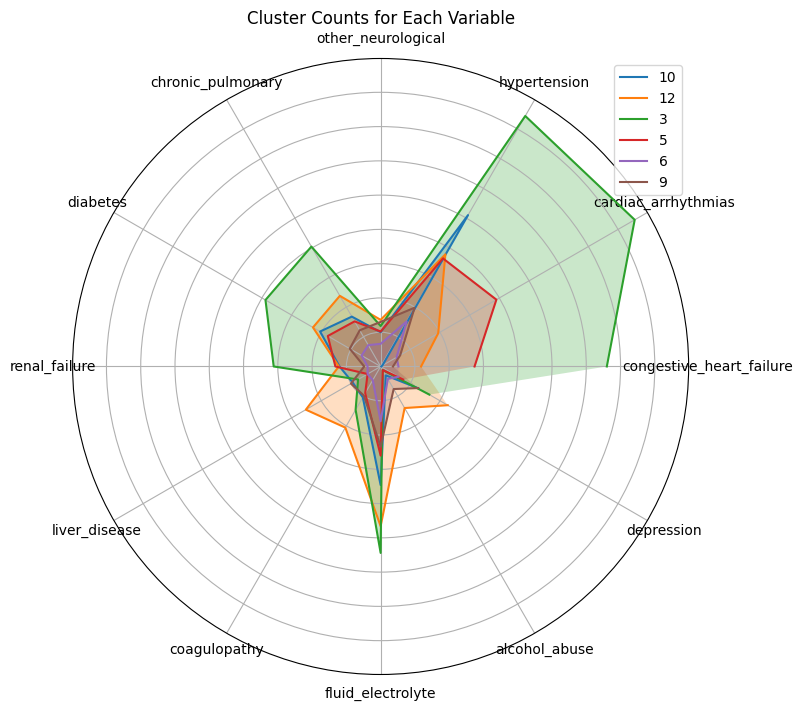

In [97]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[11, 13, 4, 6, 7, 10 ], :][['congestive_heart_failure', 'cardiac_arrhythmias', 
        'hypertension', 'other_neurological',
       'chronic_pulmonary', 'diabetes', 'renal_failure',
       'liver_disease', 'coagulopathy', 'fluid_electrolyte',
       'alcohol_abuse', 'depression']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [98]:
best_labels[labels_].value_counts()
temp_ = time_series_2d_df
temp_

,aado2,baseexcess,bicarbonate,totalco2,carboxyhemoglobin,chloride,calcium,glucose,hematocrit,hemoglobin,...,inr,pt,bun,wbc,dopamine_dose,vasopressin_dose,phenylephrine_dose,epinephrine_dose,norepinephrine_dose,urineoutput
icustay_id,,,,,,,,,,,,,,,,,,,,,
200061,-1.000000,-1.000000,0.447257,-1.000000,-1.0,0.466387,-1.000000,0.001382,0.745919,0.901820,...,0.042857,0.050376,0.049401,0.036377,-1.000000,-1.0,-1.00000,-1.0,-1.000000,0.406265
200075,-1.000000,0.926606,0.202532,0.235294,-1.0,0.529412,-1.000000,0.000450,0.394606,0.468285,...,-1.000000,-1.000000,0.048674,0.075724,-1.000000,-1.0,-1.00000,-1.0,0.029864,0.416373
200087,-1.000000,0.944954,0.379747,0.392157,-1.0,0.567227,0.463343,0.001149,0.489354,0.541092,...,-1.000000,-1.000000,0.135852,0.028458,-1.000000,-1.0,-1.00000,-1.0,0.060553,0.414039
200116,-1.000000,0.951835,0.497890,0.490196,-1.0,0.453782,0.469208,0.000811,0.525550,0.622173,...,0.032143,0.034938,0.145296,0.024251,0.222522,-1.0,-1.00000,-1.0,0.003027,0.494149
200131,-1.000000,0.954128,0.405063,0.431373,-1.0,0.472689,-1.000000,0.000898,0.462740,0.544402,...,0.045238,0.053355,0.046495,0.035635,-1.000000,-1.0,0.00296,-1.0,-1.000000,0.405744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299930,-1.000000,-1.000000,0.367089,-1.000000,-1.0,0.491597,-1.000000,0.000702,0.364798,0.385549,...,0.035714,0.043469,0.031239,0.033036,-1.000000,-1.0,-1.00000,-1.0,-1.000000,0.439115
299948,-1.000000,0.950688,0.396624,0.436275,-1.0,0.549580,0.529814,0.000684,0.404897,0.444015,...,0.041429,0.047451,0.052307,0.017570,-1.000000,-1.0,-1.00000,-1.0,-1.000000,0.415139
299949,0.611026,0.945336,0.359494,0.382353,-1.0,0.521008,0.423460,0.000876,0.350603,0.424600,...,0.040476,0.046313,0.047367,0.057906,-1.000000,-1.0,-1.00000,-1.0,-1.000000,0.440537


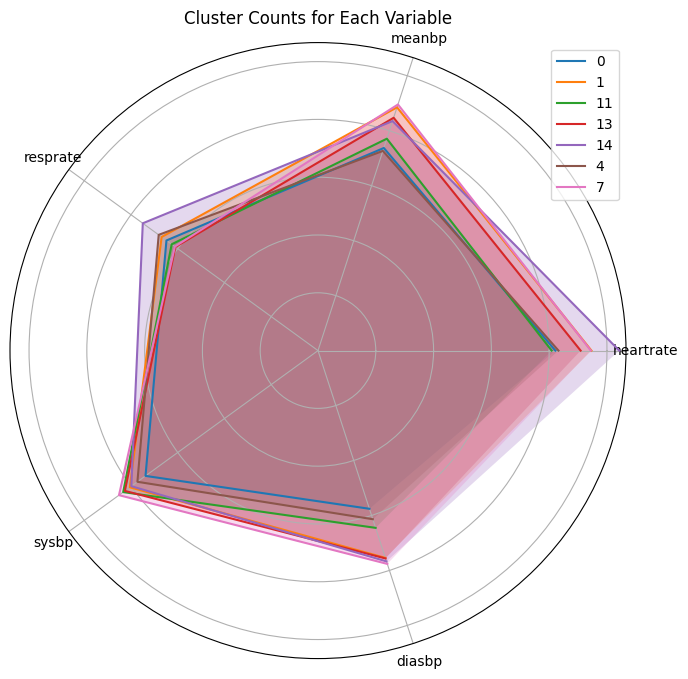

In [108]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['heartrate', 'meanbp', 'resprate', 'sysbp', 'diasbp', ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

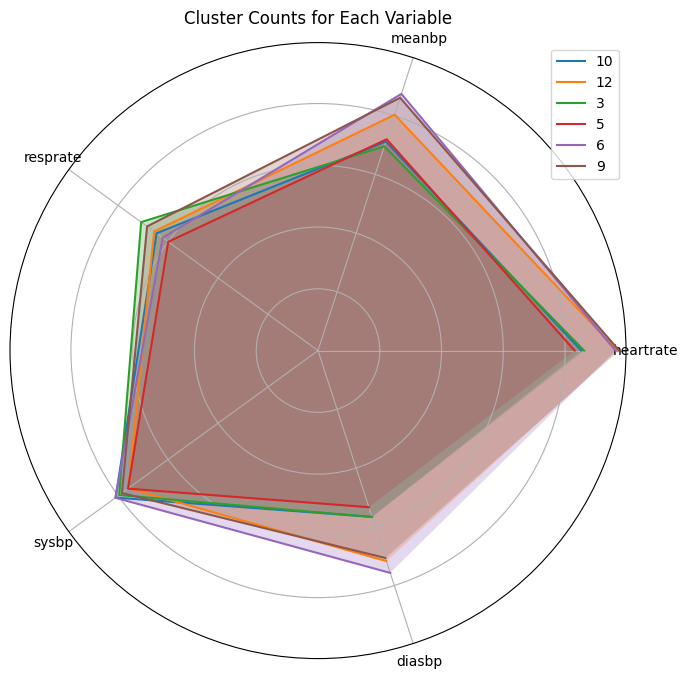

In [99]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[11, 13, 4, 6, 7, 10 ], :][['heartrate', 'meanbp', 'resprate', 'sysbp', 'diasbp', ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

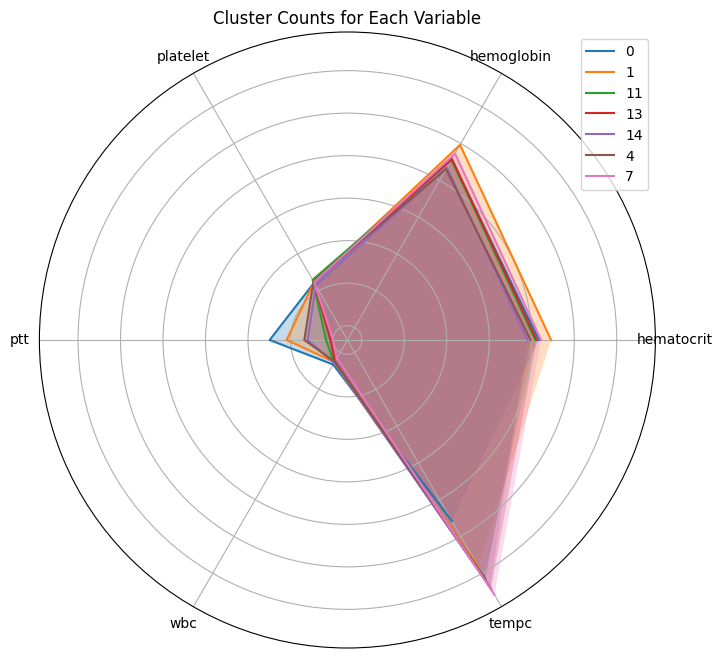

In [109]:

temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['hematocrit', 'hemoglobin', 'platelet', 'ptt', 'wbc', 'tempc' ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

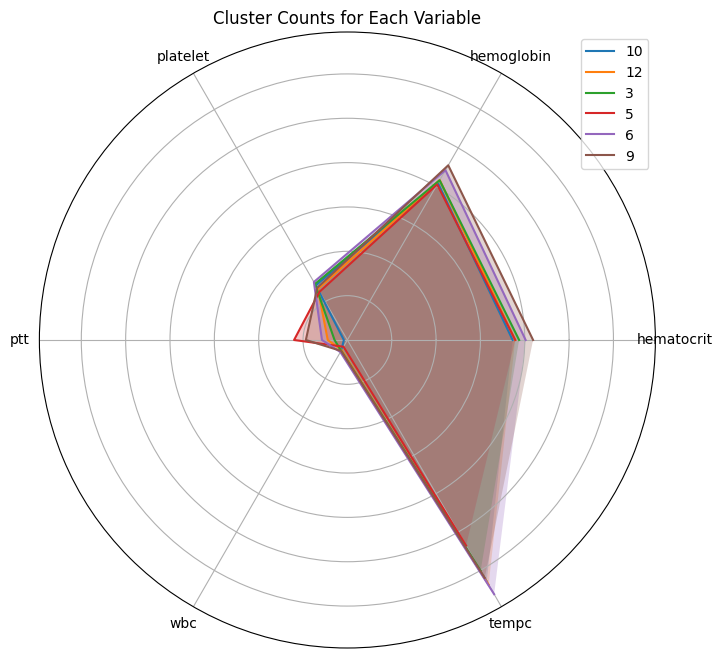

In [101]:

temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[11, 13, 4, 6, 7, 10 ], :][['hematocrit', 'hemoglobin', 'platelet', 'ptt', 'wbc', 'tempc' ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

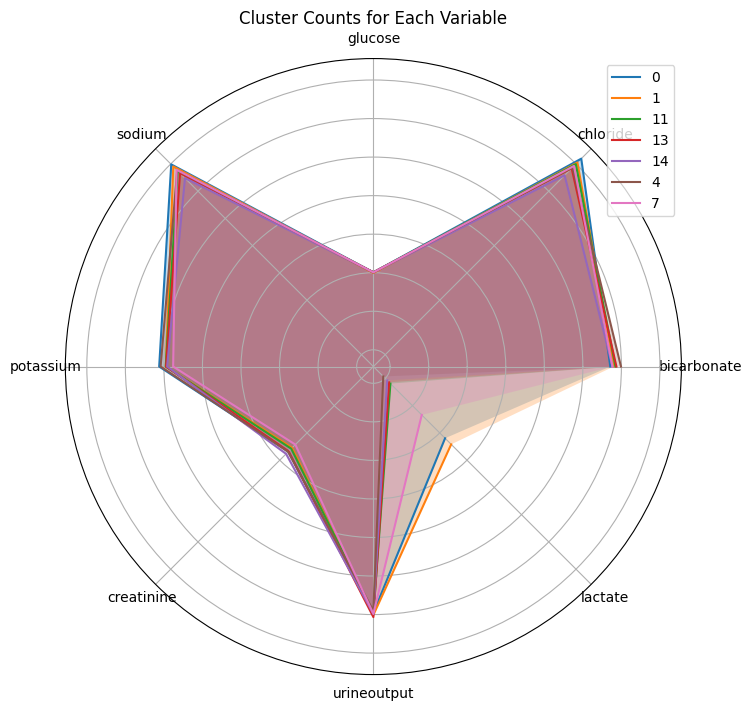

In [111]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['bicarbonate', 'chloride', 'glucose',  'sodium',
       'potassium', 'creatinine', 'urineoutput', 'lactate']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

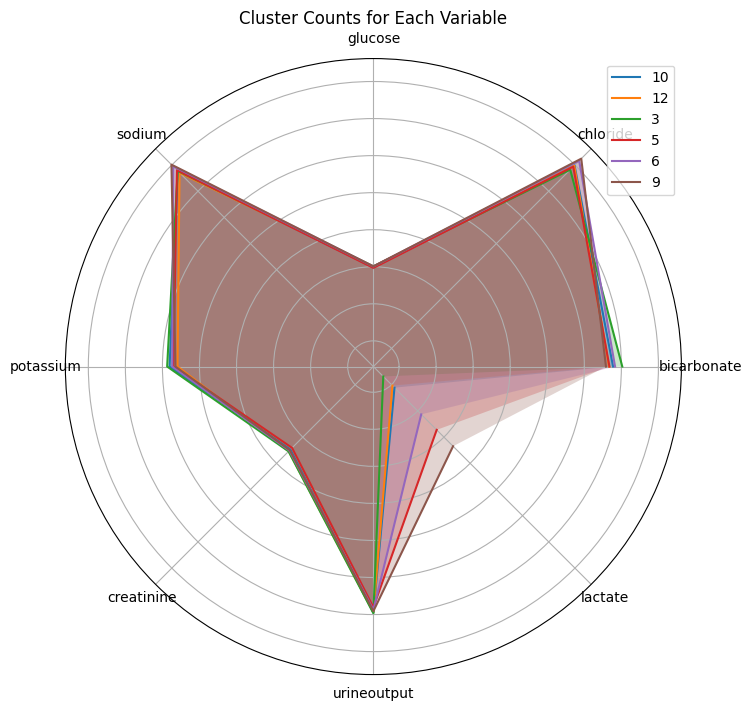

In [102]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[11, 13, 4, 6, 7, 10 ], :][['bicarbonate', 'chloride', 'glucose',  'sodium',
       'potassium', 'creatinine', 'urineoutput', 'lactate']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

## DT

In [ ]:
time_series_3d_df = time_series_3d_df.set_index('icustay_id')

In [50]:
static = static.astype(int)
columns = np.concatenate((static.columns, time_series_3d_df.columns), axis=None)
# Combine binary and continuous features
data = np.concatenate((static.values, time_series_3d_df.groupby('icustay_id').mean().values), axis=1)
mixed_data = pd.DataFrame(data, columns = columns)

In [51]:
lab = best_labels[labels_]
data.index  = lab.index
df = data.join(lab)
df = df.fillna(-10)
#to_predict  = mort_icu.mort_icu

to_predict  = sepsis3.is_male
X, y = df.values, to_predict
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7, stratify=y)
clf = tree.DecisionTreeClassifier(random_state=42, max_depth=6)
clf = clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, cv=10, scoring='f1_weighted')

scores


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [45]:
pd.DataFrame(clf.feature_importances_, index = df.columns, columns = ['FI']).sort_values(by='FI', ascending=False).head(30)

NameError: name 'clf' is not defined

In [ ]:
print("%0.2f f1 weighted with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
y_pred_test = clf.predict(x_test)
y_pred_train = clf.predict(x_train)
accuracy_score(y_test, y_pred_test)

In [ ]:
f1_score(y_test, y_pred_test, average='weighted')

In [ ]:
plt.figure(figsize=(40,30))
#c = ['-1','0','1','2','3']
#c = ['-1','0','1','2','3', '4','5','6','7','8','9','10','11', '12']

c = ['0','1']

tree.plot_tree(clf, filled=True, class_names=c, feature_names=df.columns, fontsize=6)
plt.show()